In [1]:
import pandas as pd
import numpy as np
import random as rand
import sqlite3

import torch
from torch import nn
from torch.nn import Dropout
from torch.utils.data import Dataset, DataLoader

import torchtuples as tt

from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


import utils

seed_value = 123456
torch.manual_seed(seed_value)

## Import Loan Data

### Preprocess for DeepSurv

In [3]:
features = ['CREDIT_SCORE', 'ORIG_DTI_RATIO', 'ORIG_UPB', 'ORIG_LTV', 'ORIG_INTEREST_RATE', 'UPB_Share',
           'TIMES_NOT_BEING_DELINQUENT','TIMES_BEING_DELINQUENT_30_DAYS','TIMES_BEING_DELINQUENT_60_DAYS'] 

## SETUP VARS
event_var = 'DEFAULT'
dep_var = 'REMAINING_SURVIVAL_TIME'

data = pd.read_csv('data/loans_labelled_train.csv')

# sample validation data
train_ids = data.LOAN_SEQ_NUMBER.sample(int(0.8 * len(data)), random_state=seed_value)

data_val = data[~data.LOAN_SEQ_NUMBER.isin(train_ids)].copy()
data = data[data.LOAN_SEQ_NUMBER.isin(train_ids)]

data = data[features + [event_var, dep_var]]
data_val = data_val[features + [event_var, dep_var]]

X_train, y_train, e_train, features = utils.get_features_and_outcomes(data, event_var, dep_var)
X_val, y_val, e_val, _ = utils.get_features_and_outcomes(data_val, event_var, dep_var)


data_test = pd.read_csv('data/loans_labelled_test.csv')
data_test = data_test[features + [event_var, dep_var]]

X_test, y_test, e_test, features = utils.get_features_and_outcomes(data_test, event_var, dep_var)

In [4]:
y_train = (
    np.array(y_train).astype(np.float32).flatten(),
    np.array(e_train).astype(np.float32).flatten())

y_val = (
    np.array(y_val).astype(np.float32).flatten(),
    np.array(e_val).astype(np.float32).flatten())

y_test = (
    np.array(y_test).astype(np.float32).flatten(),
    np.array(e_test).astype(np.float32).flatten())

In [5]:
# scaling
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train).astype(np.float32)
X_val = scaler.transform(X_val).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

val_data = (X_val, y_val)

print("X_train " + str(X_train.shape))
print("X_test " + str(X_test.shape))

X_train (199223, 9)
X_test (40761, 9)


## Train Model
### Baseline Survival Model

##### TODO - Tune Hyperparameter

+ Layer - [2,4,8]
+ Dropout - [0.3, 0.5, 0.7]
+ lr : [0.0001, 0.001, 0.01, 0.1]

### Model Architecture

In [6]:
# Surv. Model Architecture
class FeedforwardNN(nn.Module):
    
    def __init__(self, input_size, out_size, num_nodes, num_layers, dropout_rate=0.5):
        super(FeedforwardNN, self).__init__()
       
        
        self.first_layer = nn.Sequential(nn.Linear(input_size, num_nodes),
                                            nn.ReLU(),
                                            nn.Dropout(p = dropout_rate))
        
        self.hidden_layer = nn.Sequential(nn.Linear(num_nodes, num_nodes),
                                            nn.ReLU(),
                                            nn.Dropout(p = dropout_rate))
        
        self.hidden = nn.ModuleList([self.hidden_layer for i in range(num_layers - 1)])
            
        self.final_layer = nn.Linear(in_features=num_nodes, out_features=out_size)
        
    def forward(self, X):
        
        z = self.first_layer(X)
        
        # Propogate through Hidden Layers
        for hidden_layer in self.hidden:
            z = hidden_layer(z)
        
        # Output Layer
        out = self.final_layer(z)
        
        return out

### Hyperparameter Search

In [7]:
# Hyperparameter Search
verbose = False

In [8]:
## Model Parameter
in_features = X_train.shape[1]
output_dim = 1
out_features = 1

max_epochs = 100

# number of parameter which should be evaluated
n_search = 100

search_space = {
    'layers' : [2, 4, 6],
    'nodes' : [6, 9, 12, 50, 100, 200],
    'optim': ['Adam',  'SGD'],
    'dropout_rate' : [0.5, 0.7],
    'lr' : [0.001, 0.01],
    'batch_size': [254, 1024, 2048, 4096, 16384]
}

In [9]:
# draw some random hyperparameter from the range
def draw_hyperparameters(param):
    return search_space[param][rand.randint(0,len(search_space[param]) - 1)]

def get_optim(name):
    if name == 'Adam':
        return tt.optim.Adam
    
    ## currently not working...
    #if name == 'AdamWR':
    #    return tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
    #                        cycle_multiplier=2)
    
    return tt.optim.SGD


In [10]:
# draw random number for each feature and save as sequence
# continue drawing as long as no unique combination found

hyperparamter_results_df = None

#set of already evaluated hyperparemeters
evaluate_params = set()

iteration = 0
while(iteration < n_search):
    
    ## Draw the hyperparameter
    layers = draw_hyperparameters('layers')
    nodes = draw_hyperparameters('nodes')
    optim_name = draw_hyperparameters('optim')
    optim = get_optim(optim_name)
    dropout_rate = draw_hyperparameters('dropout_rate')
    lr = draw_hyperparameters('lr')
    batch_size = draw_hyperparameters('batch_size')
    
    ## use String representation of features to remember that they were already evaluated
    params_str = str(layers) + str(nodes) + str(optim) + str(dropout_rate) + str(lr) + str(batch_size)
    
    # in case already evaluted draw new hyperparamter
    if params_str in evaluate_params:
        continue
    
    if iteration % 10 == 0:
        print("Iteration: " + str(iteration))

    net = FeedforwardNN(input_size=in_features, out_size=output_dim, num_nodes=nodes, num_layers=layers, dropout_rate=dropout_rate)

    callbacks = [tt.callbacks.EarlyStopping()]
    
    deep_surv = CoxPH(net, optim)
    deep_surv.optimizer.set_lr(lr)
    
    # Fit the model
    log = deep_surv.fit(X_train, y_train, batch_size=batch_size, epochs=max_epochs, verbose=0,
                                callbacks=callbacks, val_data=val_data)
    
    ## Evaluate
    _ = deep_surv.compute_baseline_hazards(eval_=True)
    surv = deep_surv.predict_surv_df(X_val)
    # Concordance index
    ev = EvalSurv(surv, y_val[0], y_val[1], censor_surv='km')

    c_index = ev.concordance_td()
    min_val_loss = log.to_pandas().val_loss.min()
    min_train_loss = log.to_pandas().train_loss.min()
    # save both for best loss and for best c_index
    
    # append results
    append_row = pd.DataFrame({
        'Iteration' : [iteration],
        'Epochs' : [log.epochs[-1]],
        'Layers' : [layers],
        'Nodes' : [nodes],
        'Optimizer' : [optim_name],
        'Dropout' : [dropout_rate],
        'LR' : [lr],
        'Batch_Size' : [batch_size],
        'Train_Loss' : [min_train_loss],
        'Val_Loss' : [min_val_loss],
        'C_Index' : [c_index]
    })
    
    if hyperparamter_results_df is None:
        hyperparamter_results_df = append_row.copy()
    else:
        hyperparamter_results_df = hyperparamter_results_df.append(append_row)
    
    iteration = iteration + 1

Iteration: 0
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90


In [11]:
hyperparamter_results_df.sort_values('C_Index', ascending=False).head(40)

,Iteration,Epochs,Layers,Nodes,Optimizer,Dropout,LR,Batch_Size,Train_Loss,Val_Loss,C_Index
0,7,38,2,50,Adam,0.5,0.001,1024,5.181010,6.966514,0.881064
0,45,75,2,100,Adam,0.7,0.001,4096,6.573479,6.985101,0.880610
0,70,80,6,200,SGD,0.5,0.010,2048,5.859084,6.962104,0.880561
0,93,32,6,200,Adam,0.5,0.001,1024,5.177200,6.956124,0.880256
0,83,59,6,100,SGD,0.5,0.010,2048,5.960090,6.978081,0.879809
0,48,55,2,50,Adam,0.5,0.010,16384,7.756717,6.966621,0.879717
0,22,69,2,200,SGD,0.7,0.010,2048,5.862256,6.998157,0.879536
0,37,66,6,50,SGD,0.5,0.010,1024,5.434198,7.010114,0.879337
0,86,52,4,100,Adam,0.7,0.001,1024,5.486672,7.065028,0.879000
0,40,38,4,50,Adam,0.5,0.010,2048,6.106539,7.047025,0.878846


In [12]:
hyperparamter_results_df.to_csv('search_deep_surv.csv', index=False)

## Export best Hyperparameter

In [9]:
hyperparamter_results_df = pd.read_csv('search_deep_surv.csv')

In [13]:
in_features = X_train.shape[1]
out_features = 1
max_epochs = 100

### Train model with best hyperparamters

+ still use Early Stopping 

In [15]:
best_hyperparam = hyperparamter_results_df.sort_values('C_Index', ascending=False).iloc[0]

best_layers = best_hyperparam['Layers']
best_lr = best_hyperparam['LR']
best_nodes = best_hyperparam['Nodes']
best_optim = get_optim(best_hyperparam['Optimizer'])
best_dropout = best_hyperparam['Dropout']
best_batch_size = best_hyperparam['Batch_Size']

In [16]:
callbacks = [tt.callbacks.EarlyStopping()]
net = FeedforwardNN(input_size=in_features, out_size=out_features, 
                    num_nodes=best_nodes, num_layers=best_layers, 
                    dropout_rate=best_dropout)

deep_surv = CoxPH(net, best_optim)
deep_surv.optimizer.set_lr(best_lr)

# Fit the model
log = deep_surv.fit(X_train, y_train, batch_size=int(best_batch_size), epochs=max_epochs, verbose=1,
                            callbacks=callbacks, val_data=val_data)


0:	[0s / 0s],		train_loss: 5.8577,	val_loss: 7.2108
1:	[0s / 1s],		train_loss: 5.5063,	val_loss: 7.0644
2:	[0s / 2s],		train_loss: 5.4227,	val_loss: 7.0399
3:	[0s / 3s],		train_loss: 5.3803,	val_loss: 7.0173
4:	[0s / 4s],		train_loss: 5.3202,	val_loss: 7.0114
5:	[0s / 5s],		train_loss: 5.3092,	val_loss: 7.0147
6:	[0s / 5s],		train_loss: 5.3022,	val_loss: 6.9912
7:	[0s / 6s],		train_loss: 5.2905,	val_loss: 6.9933
8:	[0s / 7s],		train_loss: 5.2674,	val_loss: 6.9876
9:	[0s / 8s],		train_loss: 5.2917,	val_loss: 7.0129
10:	[0s / 9s],		train_loss: 5.2613,	val_loss: 6.9926
11:	[0s / 10s],		train_loss: 5.2528,	val_loss: 6.9981
12:	[0s / 10s],		train_loss: 5.2408,	val_loss: 6.9946
13:	[0s / 11s],		train_loss: 5.2488,	val_loss: 6.9869
14:	[0s / 12s],		train_loss: 5.2471,	val_loss: 6.9867
15:	[0s / 13s],		train_loss: 5.2255,	val_loss: 6.9864
16:	[0s / 14s],		train_loss: 5.2266,	val_loss: 6.9792
17:	[0s / 14s],		train_loss: 5.2153,	val_loss: 6.9689
18:	[0s / 15s],		train_loss: 5.2052,	val_loss: 6.

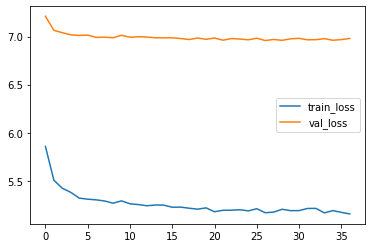

In [17]:
log.plot()

## C-Index

In [18]:
## Needed to be called before survival function can be computet
_ = deep_surv.compute_baseline_hazards(eval_=True)

In [19]:
test_c_index = utils.get_c_index(deep_surv, X_test, y_test)
test_c_index

0.8057016616972825

## Explore Feature Importance 

### Permutation Importance

In [20]:
permutation_feature_results = utils.get_permutation_results(deep_surv, X_test, y_test, n_repeats = 10)
orig_c_index = utils.get_c_index(deep_surv, X_test, y_test)

In [21]:
perc_decrease = ((np.array(permutation_feature_results) / orig_c_index) - 1) * 100

# percentage decrese of C-Index
permuattion_importance = pd.DataFrame({
        'Feature': features,
        'Delta_C_Index': perc_decrease
    })

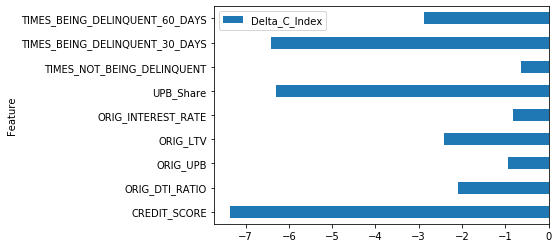

In [22]:
permuattion_importance.set_index('Feature').plot(kind='barh')

In [23]:
# Export for better visualization later
permuattion_importance.to_csv('deep_surv_permutation_importance.csv', index=False)
permuattion_importance

,Feature,Delta_C_Index
0,CREDIT_SCORE,-7.364522
1,ORIG_DTI_RATIO,-2.103488
2,ORIG_UPB,-0.940414
3,ORIG_LTV,-2.418488
4,ORIG_INTEREST_RATE,-0.811696
5,UPB_Share,-6.292050
6,TIMES_NOT_BEING_DELINQUENT,-0.636493
7,TIMES_BEING_DELINQUENT_30_DAYS,-6.406825
8,TIMES_BEING_DELINQUENT_60_DAYS,-2.877856


## Prediction


### MC-Dropout Predictions

In [24]:
deep_surv_full_predictions = utils.get_stochastic_surv_func(deep_surv, X_test, n = 100, model_name='DeepSurv_MC')
deep_surv_full_predictions

,ID,PERIOD,MODEL,PRED_80_LOW,PRED_80_HIGH,PRED_95_LOW,PRED_95_HIGH,PRED_MEAN
0,1,1,DeepSurv_MC,1.000000,1.000000,1.000000,1.000000,1.000000
1,1,2,DeepSurv_MC,0.999869,0.999997,0.999771,0.999999,0.999950
2,1,3,DeepSurv_MC,0.999736,0.999994,0.999541,0.999998,0.999899
3,1,4,DeepSurv_MC,0.999597,0.999992,0.999298,0.999997,0.999846
4,1,5,DeepSurv_MC,0.999402,0.999987,0.998959,0.999996,0.999771
...,...,...,...,...,...,...,...,...
1997284,40761,45,DeepSurv_MC,0.953803,0.991616,0.934629,0.995468,0.974416
1997285,40761,46,DeepSurv_MC,0.953409,0.991543,0.934077,0.995429,0.974196
1997286,40761,47,DeepSurv_MC,0.952714,0.991414,0.933104,0.995359,0.973809
1997287,40761,48,DeepSurv_MC,0.952194,0.991318,0.932377,0.995307,0.973520


### Write Results into DB

In [25]:
db_path = './predictions/test_evaluation.sqlite'
con = sqlite3.connect(db_path)

deep_surv_full_predictions.to_sql('TB02_PREDICTIONS', con, index=False, if_exists='append')

con.close()